In [27]:
import numpy as np
from scipy.io import loadmat
from neurorobotics_dl.models import PrototypicalModel,EEGNet
import os
from joblib import load
import torch
from tqdm.auto import tqdm

class Predictor():
    def __init__(self,):
        sbj_path = '/home/palatella/workspace/cBCI-MI-bhbf/model/all_subjects_20240208_162941'
        model_path = os.path.join(sbj_path,"model.pt")
        clf_path = os.path.join(sbj_path,"qda.joblib")
        mean_std_path = os.path.join(sbj_path,"mean_std.npz")

        self.net = PrototypicalModel(EEGNet( 32, 
                                        Chans = 32, 
                                        Samples = 512,
                                        dropoutRate = 0,
                                        kernLength = 256,
                                        F1 = 8, 
                                        D = 2, 
                                        F2 = 16),metric='euclidean')

        self.net.load_state_dict(torch.load(model_path))
        self.clf = load(clf_path) 
        cc = np.load(mean_std_path)
        self.mu, self.sigma = cc['mu'], cc['sigma']

    def __call__(self,x):
        x = (x-self.mu)/self.sigma
        emb = self.net.compute_embeddings(x)
        pred = [0 for _ in range(len(self.clf.classes_))]
        pred[int(self.clf.predict(emb))] = 1
        probs = self.clf.predict_proba(emb)[0].tolist()
        return pred, probs

In [28]:
eeg = loadmat('/home/palatella/workspace/cBCI-data/g1.20240115.153338_filtered.mat')['eeg']
predictor = Predictor()

In [29]:
nSamples = 512
shift = 32

preds = []
probs = []

for i in tqdm(range((len(eeg)-nSamples)//shift)):
    data = torch.from_numpy(eeg[i*shift:i*shift+nSamples].astype(np.float32)).T.reshape(1,32,1,512)
    pred,prob = predictor(data)
    preds.append(pred)
    probs.append(prob)
probs = np.array(probs)
preds = np.array(preds)

  0%|          | 0/5568 [00:00<?, ?it/s]

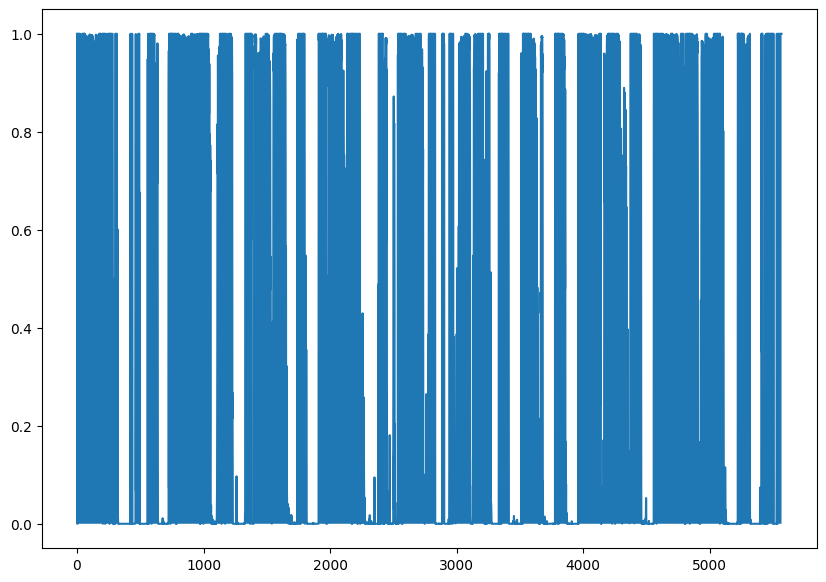

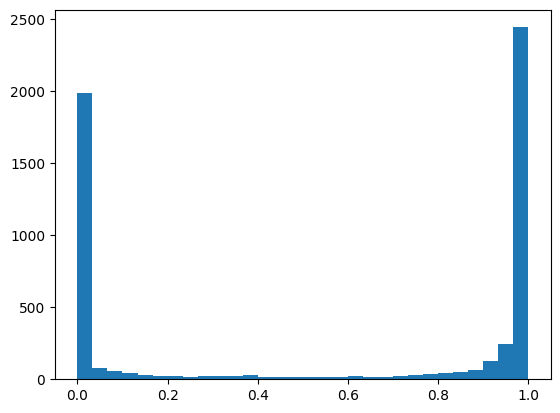

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(probs[:,0])
plt.fill_between(range(len(preds)),probs[:,0])
plt.show()
plt.hist(probs[:,0],bins=30)
plt.show()

In [4]:
nSamples = 512
shift = 32

preds = []
probs = []

for i in tqdm(range((len(eeg)-nSamples)//shift)):
    data = torch.from_numpy(eeg[i*shift:i*shift+nSamples].astype(np.float32)).reshape(1,32,1,512)
    pred,prob = predictor(data)
    preds.append(pred)
    probs.append(prob)
probs = np.array(probs)
preds = np.array(preds)

  0%|          | 0/5568 [00:00<?, ?it/s]

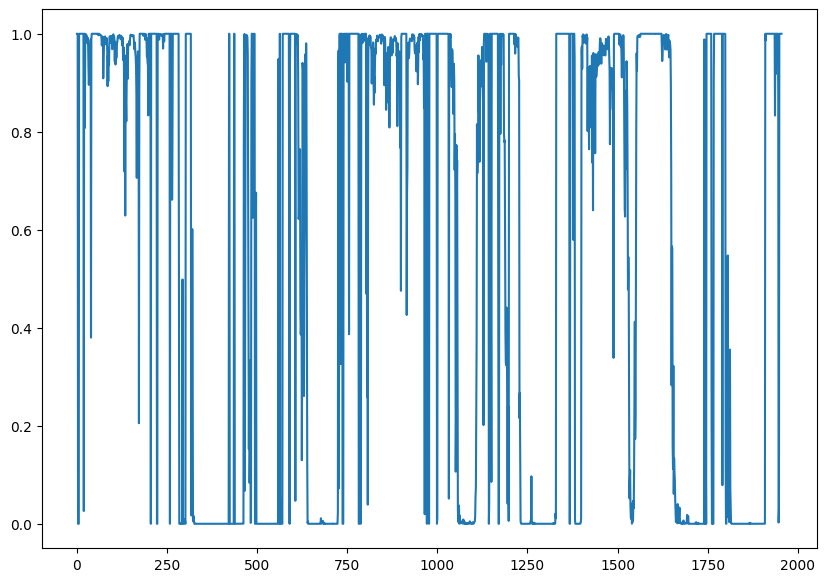

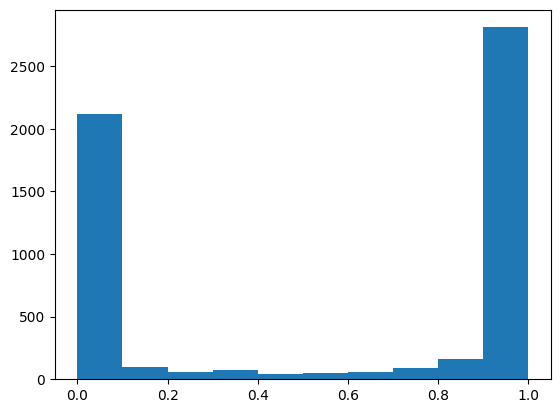

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(probs[:1956,0])
plt.show()

plt.hist(probs[:,0])
plt.show()